# House Rental

## Subject

### Helping to evaluate vacation renting sites

__Short description__: This project is concentrated on the evaluating renting advertisements by studying the electricity consumption in towns where the property is advertised. In the context of users choosing different destinations for vacations, provide them an additional information on those places in terms of environmental conditions. The environmental condition in our limited example is based on the electrical consumption in the destination town.

__Further details__: In France, several house rental web sites have RSS XML flow that can be parsed into a data set containing the list of available rentals. You will find the names of the towns inside the text.

At the same time you have the CSV file from [ENEDIS](https://data.enedis.fr/explore/dataset/consommation-electrique-par-secteur-dactivite-commune/) containing the history of electricity consumption allowing you to estimation how much and for which purpose the energy is consumed. Thus you can provide every community with the “electrical” description, where you will calculate different indicators, such as for example, 
* part/amount of non-resident consumption, which might indicate the importance of the industrial installations in the town.
* evolution of the residencial consumption for several years, which might indicate the growth factor of the town
* evolution of the non-residential consumption
* other indicators left to you

Putting both data sources together allows you to sort/filter the rental advertisements by the “energy” indicators, as, for example, “zero industry” advertisements - quiet locations. To find an exact usage is left to you as a part of the exercise.

## Code

### Imports

In [1]:
import sys
import pandas as pd
import re
import numpy as np
import feedparser
from bokeh import io, plotting, layouts, models, palettes
import cufflinks as cf
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
plotly.tools.set_credentials_file(username='enzobes', api_key='NbVOe5BmvoI0upllgZ6J')

pd.options.display.max_columns= 200
pd.options.display.max_rows= 200

In [2]:
base = "http://www.ty-gites.com/rss/"
location = "locations_vacances_"
regions = ["alsace",
           "aquitaine",
           "auvergne",
           "bourgogne",
           "bretagne",
           "centre_val_de_loire",
           "champagne_ardenne",
           "corse",
           "franche_comte",
           "ile_de_france",
           "languedoc_roussillon",
           "limousin",
           "lorraine",
           "midi_pyrenees",
           "nord_pas_de_calais",
           "normandie",
           "pays_de_la_loire",
           "picardie",
           "poitou_charentes",
           "provence_alpes_cote_d_azur",
           "rhone_alpes",
           "outre_mer"]

### Parsing RSS feeds into Dataframe

In [3]:
feeds, items = [], []
cpt = 0
regex = r"-\s(\w|-)*\s-"
for region in regions:
    url = base+location+region+".xml"
    feeds.append(feedparser.parse(url))

for feed in feeds:
    for item in feed.entries:
        m = re.search(regex, item.title)
        if m:
            items.append((item.title, m.group(0)[1:-1].lower().strip(), item.published, item.summary, item.link))
        else:
            cpt+=1

rents = pd.DataFrame(items, columns=['titre', 'nom_commune', 'date_publication', 'description', 'lien'])
print("Il manque %d entrées" % cpt)
rents.head()

Il manque 89 entrées


,titre,nom_commune,date_publication,description,lien
0,Gîte Le nid des hirondelles - KOGENHEIM -,kogenheim,"Wed, 28 Mar 2018 23:52:48 GMT","Le gîte ""LE NID DES HIRONDELLES"", est situé au...",http://www.ty-gites.com/location-gite-kogenhei...
1,Gîte Gites-Weyer - BERGHEIM -,bergheim,"Wed, 28 Mar 2018 13:58:57 GMT","""Elégants et coquets, nos appartements sont un...",http://www.ty-gites.com/location-gite-bergheim...
2,Gîte en CENTRE ALSACE proche de SELESTAT - NE...,neubois,"Sun, 25 Mar 2018 20:34:55 GMT",disponible pour MARCHES DE NOEL du 11 au 23 dé...,"http://www.ty-gites.com/location-gite-neubois,..."
3,Gîte Au murmure de l'eau - Ebersheim -,ebersheim,"Sat, 24 Mar 2018 09:23:35 GMT",Au murmure de l'eau gîte rural de Patrick Stin...,http://www.ty-gites.com/location-gite-ebershei...
4,Chalet Le Rebberg - Soultzeren -,soultzeren,"Fri, 23 Mar 2018 22:39:57 GMT",Bienvenue dans notre chalet!\nA 2 et jusqu'à 8...,http://www.ty-gites.com/location-chalet-soultz...


In [4]:
conso = pd.read_csv( "datasets/conso.csv" , delimiter = ";" )

dataEnedis = pd.DataFrame(data=conso)
dataEnedis.columns = [x.strip().replace(' ', '_').lower() for x in dataEnedis.columns]
dataEnedis['nom_commune'] = dataEnedis['nom_commune'].str.lower()
#dataEnedis['année'] = pd.to_datetime( dataEnedis['année'] , format = "%Y" )
dataEnedis.head()

,année,nom_commune,code_commune,nom_epci,code_epci,type_epci,nom_département,code_département,nom_région,code_région,nb_sites_résidentiel,conso_totale_résidentiel_(mwh),conso_moyenne_résidentiel_(mwh),nb_sites_professionnel,conso_totale_professionnel_(mwh),conso_moyenne_professionnel_(mwh),nb_sites_agriculture,conso_totale_agriculture_(mwh),nb_sites_industrie,conso_totale_industrie_(mwh),nb_sites_tertiaire,conso_totale_tertiaire_(mwh),nb_sites_secteur_non_affecté,conso_totale_secteur_non_affecté_(mwh),nombre_d'habitants,taux_de_logements_collectifs,taux_de_résidences_principales,superficie_des_logements_<_30_m2,superficie_des_logements_30_à_40_m2,superficie_des_logements_40_à_60_m2,superficie_des_logements_60_à_80_m2,superficie_des_logements_80_à_100_m2,superficie_des_logements_>_100_m2,résidences_principales_avant_1919,résidences_principales_de_1919_à_1945,résidences_principales_de_1946_à_1970,résidences_principales_de_1971_à_1990,résidences_principales_de_1991_à_2005,résidences_principales_de_2006_à_2010,résidences_principales_après_2011,taux_de_chauffage_électrique,geo_shape,geo_point_2d
0,2011,la chapelle-saint-maurice,74060,CC de la Rive Gauche du Lac d'Annecy,247400732,CC,Haute-Savoie,74,Auvergne-Rhône-Alpes,84,63.0,388.407654,6.165201,17.0,123.886227,7.287425,0,0.0,0,0.000000,1,33.605294,0,0.0,134,28.955467,87.226330,1.818182,1.818182,9.090909,38.181818,23.636364,25.454545,36.363636,5.454545,7.272727,21.818182,12.727273,10.909091,5.454545,36.363636,NaN,NaN
1,2015,thaumiers,18261,CC le Dunois,241800424,CC,Cher,18,Centre-Val de Loire,24,257.0,1644.113231,6.397328,34.0,232.732521,6.845074,0,0.0,1,9.031000,0,0.000000,0,0.0,414,0.749064,75.107296,0.000000,1.714286,7.428571,23.428571,26.285714,41.142857,65.142857,12.571429,4.571429,7.428571,2.285714,6.285714,1.714286,17.714286,NaN,NaN
2,2013,neuville-sur-saône,69143,CU de Lyon,246900245,CU,Rhône,69,Auvergne-Rhône-Alpes,84,3602.0,13663.962722,3.793438,750.0,6758.088071,9.010784,0,0.0,16,36270.708649,42,9052.230987,0,0.0,7242,72.548244,99.786579,4.208236,5.383414,18.980476,31.729883,21.571045,18.126951,12.693790,6.374103,24.723784,35.053170,12.476466,8.678691,0.000000,17.437240,NaN,NaN
3,2011,lachapelle-sous-rougemont,90058,CC du Pays Sous Vosgien,249000217,CC,Territoire-de-Belfort,90,Bourgogne-Franche-Comté,27,271.0,1523.843323,5.623038,46.0,469.457076,10.205589,0,0.0,2,2138.948712,1,103.714138,0,0.0,597,36.191962,98.377403,1.652911,3.305781,15.289254,11.570255,25.206599,42.975199,37.190072,6.611563,9.504127,12.809908,19.008253,13.636384,1.239693,28.512380,NaN,NaN
4,2016,seyre,31546,CC Coteaux du Lauragais Sud (Co.Laur.Sud),243100179,CC,Haute-Garonne,31,Occitanie,76,53.0,438.788782,8.279034,11.0,22.572683,2.052062,0,0.0,0,0.000000,0,0.000000,0,0.0,108,1.879739,91.391091,0.000000,0.000000,2.127638,10.638190,12.766082,74.468091,23.404272,2.127638,12.766082,17.021358,14.893720,6.382914,23.404017,34.042461,"{""type"": ""Polygon"", ""coordinates"": [[[1.678708...","43.3635974739, 1.66366858427"


In [5]:
codeCommune = pd.DataFrame(columns=['nom_commune', 'code_commune', "nombre_d'habitants"])

codeCommune['nom_commune'] = conso["nom_commune"].values
codeCommune['code_commune'] = conso["code_commune"]
codeCommune["nombre_d'habitants"] = conso["nombre_d'habitants"]
codeCommune = codeCommune.drop_duplicates()
CommuneByPeople = codeCommune.sort_values(["nombre_d'habitants"], ascending = False)
CommuneByPeople.head(10)



,nom_commune,code_commune,nombre_d'habitants
13230,toulouse,31555,458298
11412,nice,6088,342294
25498,nantes,44109,292717
10021,montpellier,34172,272083
434,bordeaux,33063,243625
13567,lille,59350,231490
68824,rennes,35238,211372
1778,reims,51454,182592
52569,le havre,76351,172073
8543,saint-étienne,42218,172022


*On supprime les champs inutiles du dataset*

In [6]:
df_enedis = dataEnedis.drop(['geo_shape','geo_point_2d','nom_epci'], axis=1)

In [7]:
merged = codeCommune.merge(rents, on='nom_commune',how='inner')
merged.head()

,nom_commune,code_commune,nombre_d'habitants,titre,date_publication,description,lien
0,trentels,47315,818,Gîte La Granja - Trentels -,"Fri, 23 Mar 2018 20:07:19 GMT",La granja est élu comme meilleur logies en Fra...,http://www.ty-gites.com/location-gite-trentels...
1,chalabre,11091,1107,Gîte Aragou 100M2 - chalabre -,"Sun, 04 Mar 2018 23:14:29 GMT",Pays Cathare entre Mer Méditerranée et Pyrénée...,http://www.ty-gites.com/location-gite-chalabre...
2,chalabre,11091,1107,Gîte Tivoli 40M2 - chalabre -,"Sun, 04 Mar 2018 23:13:59 GMT",Bien située en moyenne montagne dans joli vill...,http://www.ty-gites.com/location-gite-chalabre...
3,servon,77450,3138,Gîte sauvage - servon -,"Wed, 28 Feb 2018 17:08:55 GMT",Ancien pigeonnier restauré au grand manoir de ...,"http://www.ty-gites.com/location-gite-servon,4..."
4,servon,50574,264,Gîte sauvage - servon -,"Wed, 28 Feb 2018 17:08:55 GMT",Ancien pigeonnier restauré au grand manoir de ...,"http://www.ty-gites.com/location-gite-servon,4..."


 #  Check if any value is NaN in DataFrame

Si la fonction retourne `True` alors il existe des colonnes qui contiennent `Nan` en donnée 

In [8]:
isNull = False
while isNull == False:
    for i in df_enedis.isnull().values.any(axis=1):
        if i == True:
            isNull = i

print(isNull)

True


  Generation de Graphique avec Bohek à partir du fichier ENEDIS

In [9]:
io.output_notebook()

Loading BokehJS ...

In [10]:
years_sorted = sorted(df_enedis['année'].unique())
years_sorted

[2011, 2012, 2013, 2014, 2015, 2016]

In [11]:
p = plotting.figure(plot_width=950, plot_height=400)

r = p.line(years_sorted,df_enedis[df_enedis["nom_commune"] == 'bourbriac']['conso_totale_industrie_(mwh)'], line_width=2)

plotting.show(p)

In [12]:
df_enedis = df_enedis.sort_values(['nb_sites_résidentiel'], ascending=False)
df_enedis.head()

,année,nom_commune,code_commune,code_epci,type_epci,nom_département,code_département,nom_région,code_région,nb_sites_résidentiel,conso_totale_résidentiel_(mwh),conso_moyenne_résidentiel_(mwh),nb_sites_professionnel,conso_totale_professionnel_(mwh),conso_moyenne_professionnel_(mwh),nb_sites_agriculture,conso_totale_agriculture_(mwh),nb_sites_industrie,conso_totale_industrie_(mwh),nb_sites_tertiaire,conso_totale_tertiaire_(mwh),nb_sites_secteur_non_affecté,conso_totale_secteur_non_affecté_(mwh),nombre_d'habitants,taux_de_logements_collectifs,taux_de_résidences_principales,superficie_des_logements_<_30_m2,superficie_des_logements_30_à_40_m2,superficie_des_logements_40_à_60_m2,superficie_des_logements_60_à_80_m2,superficie_des_logements_80_à_100_m2,superficie_des_logements_>_100_m2,résidences_principales_avant_1919,résidences_principales_de_1919_à_1945,résidences_principales_de_1946_à_1970,résidences_principales_de_1971_à_1990,résidences_principales_de_1991_à_2005,résidences_principales_de_2006_à_2010,résidences_principales_après_2011,taux_de_chauffage_électrique
21048,2016,paris,75056,200054781,ME,Paris,75,Île-de-France,11,1361346.0,4.292061e+06,3.152807,243233.0,2.171302e+06,8.926841,80,4697.354427,1766,442624.947989,24995,6.552349e+06,127,9494.415989,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32501,2015,paris,75056,ZZZZZZZZZ,ZZ,Paris,75,Île-de-France,11,1359902.0,4.224392e+06,3.106394,243062.0,2.137171e+06,8.792700,87,5403.987424,1720,423817.567782,24285,6.547230e+06,484,50605.169496,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24281,2014,paris,75056,ZZZZZZZZZ,nd,Paris,75,Île-de-France,11,1359809.0,4.139075e+06,3.043865,243990.0,2.131140e+06,8.734538,88,5238.397588,1701,376181.679332,23932,6.500968e+06,496,46211.504811,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87621,2013,paris,75056,ZZZZZZZZZ,nd,Paris,75,Île-de-France,11,1358484.0,4.627239e+06,3.406178,244632.0,2.298164e+06,9.394373,87,6514.212426,1655,390428.657596,23585,6.809824e+06,528,66938.533647,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63589,2012,paris,75056,ZZZZZZZZZ,nd,Paris,75,Île-de-France,11,1356777.0,4.538555e+06,3.345100,244735.0,2.289787e+06,9.356190,86,6356.195223,1556,375621.389189,23093,6.717927e+06,544,44506.865476,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

nb_site_resident = df_enedis['nb_sites_résidentiel'].head(10)
nb_site_pro = df_enedis['nb_sites_professionnel'].head(10)
nb_site_indus = df_enedis['nb_sites_industrie'].head(10)

nom_commune = CommuneByPeople['nom_commune'].head(10)

residents = []
pros = []
indus = []
communes = []
for item in nom_commune:

    communes.append(item)

for item in nb_site_resident:

    residents.append(item)
    
for item in nb_site_pro:

    pros.append(item)
    
for item in nb_site_indus:

    indus.append(item)
    
print(communes)


trace0 = go.Bar(
            x=communes,
            y=residents,
            name = "Site pro"
)

trace1 = go.Bar(
            x=communes,
            y=pros,
            name = "Site résidents"
)
trace2 = go.Bar(
            x=communes,
            y=indus,
            name = "Site Industriel"
)


data = [trace0, trace1, trace2]
layout = go.Layout(showlegend=True)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

['toulouse', 'nice', 'nantes', 'montpellier', 'bordeaux', 'lille', 'rennes', 'reims', 'le havre', 'saint-étienne']


### Looking for houses


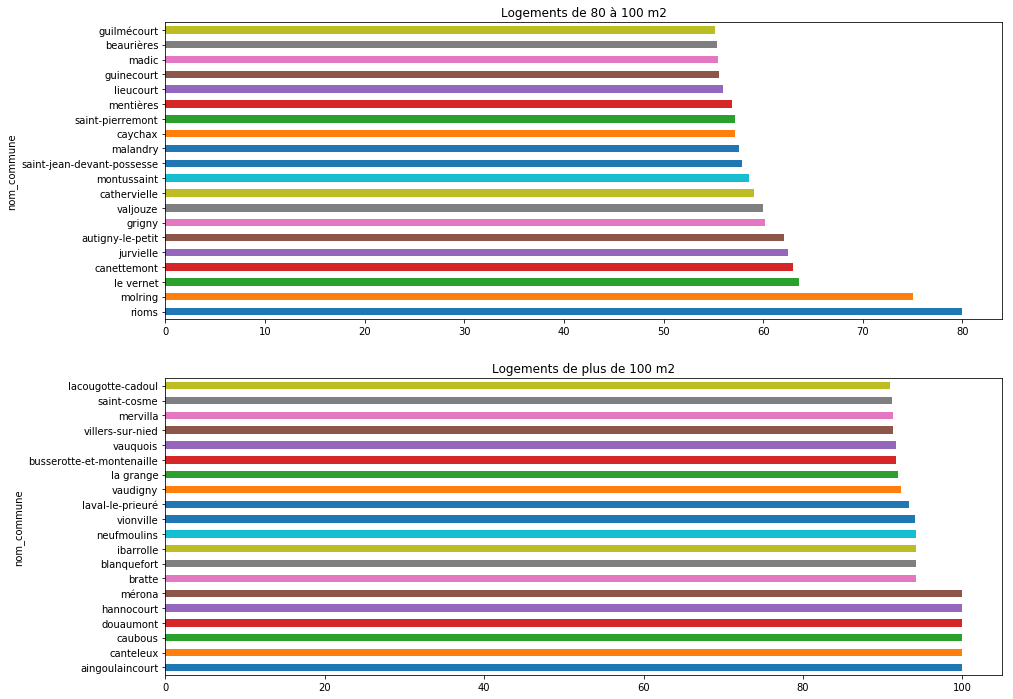

In [45]:
import matplotlib.pyplot as plt

f, a = plt.subplots(2,1)

df_enedis.groupby("nom_commune").agg({"superficie_des_logements_80_à_100_m2":"max"})['superficie_des_logements_80_à_100_m2'].nlargest(20).plot(title="Logements de 80 à 100 m2", x="Nb. logements", y="Communes", kind="barh",figsize=(15,12), ax=a[0])
df_enedis.groupby("nom_commune").agg({"superficie_des_logements_>_100_m2":"max"})['superficie_des_logements_>_100_m2'].nlargest(20).plot(title="Logements de plus de 100 m2", x="Nb. logements", y="Communes", kind="barh",figsize=(15,12), ax=a[1])